In [10]:
import numpy as np
import astropy.units as u
from astropy.time import Time
import ssa
import lmfit
import glob
import tqdm
import pandas as pd
from parse import parse_odjob

import time

import matplotlib.pyplot as plt
import ipyvolume as ipv
from astropy.table import QTable
from astropy.coordinates import Longitude, Latitude
from ipywidgets import interact
import ipywidgets as widgets

import ssa.io

In [11]:
#we'll just use one of the ODjobs truths to motivate the problem

truth = np.loadtxt('../data/odjobs_data/ODJobs_Simulated_Data_20001_20005/20001_tim_tle.txt',dtype=str,delimiter='\t')
truth_id = 0
#ssa.Orbit.fromTLE?
r_truth, v_truth, epoch_truth = ssa.io.rv_from_tle_tuple((truth[2*truth_id],truth[2*truth_id+1]))
truth_orbit = ssa.orbit.Orbit(r_truth,v_truth,epoch_truth)


In [4]:
# in the real situation we'll be given an IOD with covariances from the vendor
# and we'll sample from their covariances and propagate their samples 
# instead for now let's assume their samples are centered on the true value

n=1000
r_rand = np.zeros([3,n])
v_rand = np.zeros([3,n])

# assume an equal 1000 m and 100 m/s uncertainty on each element
for i in range(n):
    for j in range(3):
        r_bump = np.random.normal(0,1000)
        v_bump = np.random.normal(0,100)
        r_rand[j,i]=r_truth[j]+r_bump
        v_rand[j,i]=v_truth[j]+v_bump
        
# propagate the truth
prop = ssa.propagator.SGP4Propagator()
r30,v30 = ssa.compute.rv(truth_orbit,epoch_truth+30*60,propagator=prop)

# propagate the particles
r_rand_30 = np.zeros([3,n])
v_rand_30 = np.zeros([3,n])

for i in range(n):
    tmp_orbit = ssa.orbit.Orbit(r_rand[:,i],v_rand[:,i],epoch_truth)
    tmp_r,tmp_v = ssa.compute.rv(tmp_orbit,epoch_truth+30*60,propagator=prop)
    r_rand_30[:,i]=tmp_r
    v_rand_30[:,i]=tmp_v



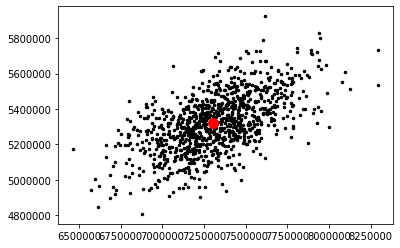

In [7]:
plt.plot(r_rand_30[1],r_rand_30[2],'k.',ms=5)
plt.plot(r30[1],r30[2],'r.',ms=20)

In [8]:
r_earth = 6.371e6 #meters
r_obs = r30/ssa.utils.norm(r30)*r_earth

rand_ang = np.zeros(n)
for i in range(n):
    tmp_r = r_rand_30[:,i]
    rand_ang[i]=ssa.utils.unitAngle3(r_obs/ssa.utils.norm(r_obs),tmp_r/ssa.utils.norm(tmp_r))
    


Text(0.5, 0, 'Angular distance from truth [arcmin]')

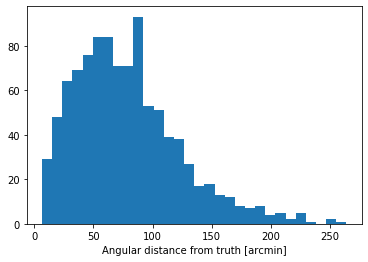

In [9]:
plt.hist(rand_ang*180/np.pi*60,bins=30)
plt.xlabel('Angular distance from truth [arcmin]')

still need to come up with proper metric for comparing the positional uncertainty of the samples to the true position, which may or may not have uncertainty on it's own just to standard drag and other physics not included in the propagator...? 